In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import os
import warnings; warnings.simplefilter('ignore')
import anndata
import scrublet as scr

import seaborn as sns
sns.set_style('white')

np.random.seed(0)
sc.settings.verbosity = 3 
sc.set_figure_params(scanpy=True, dpi=80)

In [2]:
sc.logging.print_versions()

scanpy==1.4.5 anndata==0.7.5 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


## Original 4 samples (x197, x198, x205, x422)

### Import and clean data

In [3]:
adata1 = anndata.read_csv('data/X197_TCR_DBEC_MolsPerCell.csv',first_column_names=True)
ann1 = pd.read_csv('data/X197_TCR_VDJ_annotated-update.csv',index_col=0)

adata2 = anndata.read_csv('data/Combined_X198_TCR_DBEC_MolsPerCell.csv',first_column_names=True)
ann2 = pd.read_csv('data/X198_annotated VDJ_update.csv',index_col=0)
tag2 = pd.read_csv('data/X198_TCR_Sample_Tag_Calls.csv',index_col=0)

adata3 = anndata.read_csv('data/X205_DBEC_MolsPerCell.csv',first_column_names=True)
ann3 = pd.read_csv('data/X205_annotated VDJ_update.csv',index_col=0)

adata4 = anndata.read_csv('data/Combined_X422_TCR_DBEC_MolsPerCell.csv',first_column_names=True)
ann4 = pd.read_csv('data/X422_TCR_VDJ_annotated-update.csv',index_col=0)
tag4 = pd.read_csv('data/X422_TCR_Sample_Tag_Calls.csv',index_col=0)

In [4]:
ann1['antigen'] = np.NaN
ann1['antigen'][~ann1['Neoantigen'].isna()] = 'neoantigen'
ann1['antigen'][~ann1['self'].isna()] = 'self'
ann1['antigen'][~ann1['viral'].isna()] = 'viral'

ann2['antigen'] = np.NaN
ann2['antigen'][ann2['CD4_neo'] == 1.0] = 'neoantigen'
ann2['antigen'][ann2['CD8_neo'] == 1.0] = 'neoantigen'
ann2['antigen'][ann2['viral'] == 1.0] = 'viral'

ann3['antigen'] = np.NaN
ann3['antigen'][ann3['CD4_neo'] == 1.0] = 'neoantigen'
ann3['antigen'][ann3['CD4_self'] == 1.0] = 'self'

ann4['antigen'] = np.NaN
ann4['antigen'][~ann4['Neoantigen'].isna()] = 'neoantigen'
ann4['antigen'][~ann4['self'].isna()] = 'self'
ann4['antigen'][~ann4['viral'].isna()] = 'viral'

In [5]:
ann1.index = ann1.index.astype('str')

ann2.index = ann2.index.astype('str')
tag2.index = tag2.index.astype('str')

ann3.index = ann3.index.astype('str')

ann4.index = ann4.index.astype('str')
tag4.index = tag4.index.astype('str')

In [6]:
adata1.obs = adata1.obs.join(ann1)

adata2.obs = adata2.obs.join(ann2)
adata2.obs = adata2.obs.join(tag2)

adata3.obs = adata3.obs.join(ann3)

adata4.obs = adata4.obs.join(ann4)
adata4.obs = adata4.obs.join(tag4)

### Combine into single anndata object

In [7]:
adata = adata1.concatenate([adata2, adata3, adata4])

In [8]:
adata.obs['patient'] = 'X197'
adata.obs['patient'][adata.obs['batch'] == '1'] = 'X198'
adata.obs['patient'][adata.obs['batch'] == '2'] = 'X205'
adata.obs['patient'][adata.obs['batch'] == '3'] = 'X422'

In [9]:
adata.var['name'] = adata.var.index.values
adata.var['type'] = 'gene'

for x in range(len(adata.var.index)):
    if adata.var.index[x][-4:] == 'pAbO':
        adata.var['type'][x] = 'protein'

for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, '|')[0]})
    
for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, ':')[0]})

### Filter low quality cells & doublets

In [10]:
sc.pp.filter_cells(adata,min_counts=100)

filtered out 49 cells that have less than 100 counts


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
sc.pp.filter_cells(adata,min_genes=10)

filtered out 2 cells that have less than 10 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 18.2 seconds


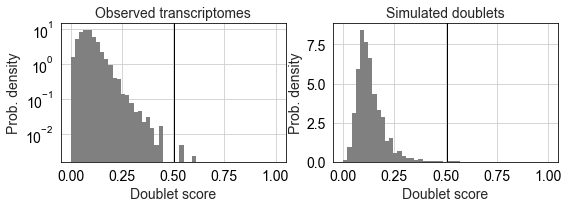

In [12]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
adata = adata[~adata.obs['predicted_doublets']]

In [13]:
adata = adata[adata.obs['Sample_Name'] != 'Undetermined']
adata = adata[adata.obs['Sample_Name'] != 'Multiplet']

In [14]:
adata = adata[adata.obs['sample'] != "8_4_lymph_node"]

### Normalize and batch correct

In [15]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:
/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/_utils.py:342: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
adata_ab = adata[:,adata.var['type'] == 'protein']

for x in adata_ab.var.index:
    adata_ab.var = adata_ab.var.rename(index={x:x+" (ab)"})
    
for x in adata_ab.var.index:
    y = x[:-5]
    adata.obs[x] = np.sum(adata[:,y].X,axis=1)
    
adata = adata[:,adata.var['type'] == 'gene']

In [17]:
adata.var_names_make_unique()

In [18]:
sc.pp.combat(adata)

... storing 'Neoantigen' as categorical
... storing 'self' as categorical
... storing 'viral' as categorical
... storing '%Blood' as categorical
... storing 'enrich' as categorical
... storing 'TCR_Beta_Delta_CDR3_Nucleotide_Dominant' as categorical
... storing 'TCR_Beta_Delta_CDR3_Translation_Dominant' as categorical
... storing 'Cell_Type_Experimental' as categorical
... storing 'antigen' as categorical
... storing 'CD4_neo_antigen' as categorical
... storing 'sample' as categorical
... storing 'Sample_Tag' as categorical
... storing 'Sample_Name' as categorical
... storing 'patient' as categorical
... storing 'type' as categorical


Standardizing Data across genes.



/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


Found 4 batches

Found 0 numerical variables:
	

Found 12 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [19]:
adata_all = adata.copy()

### Export CD4 T cells

In [20]:
adata = adata_all[(adata_all.obs['Cell_Type_Experimental'] == 'T_CD4_memory') | (adata_all.obs['Cell_Type_Experimental'] == 'T_CD4_naive')]

In [21]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [22]:
sc.set_figure_params(scanpy=True, dpi=80)

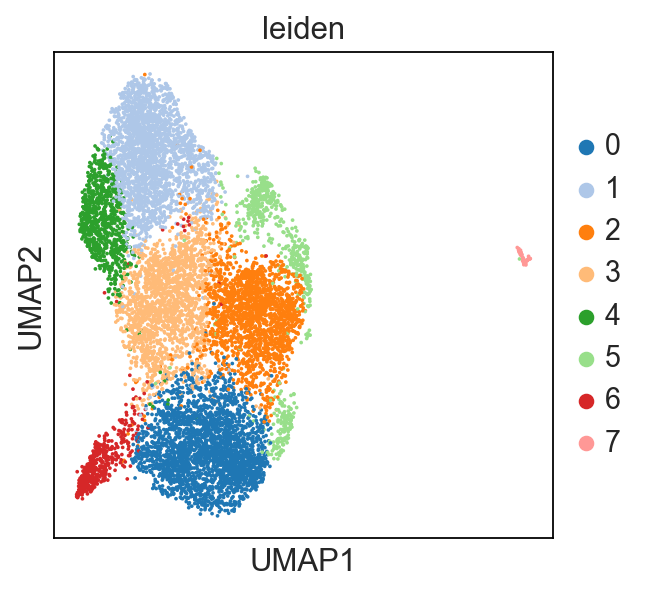

In [23]:
sc.pl.umap(adata, color='leiden',
           palette=sns.color_palette("tab20", 8),
           alpha = 1)

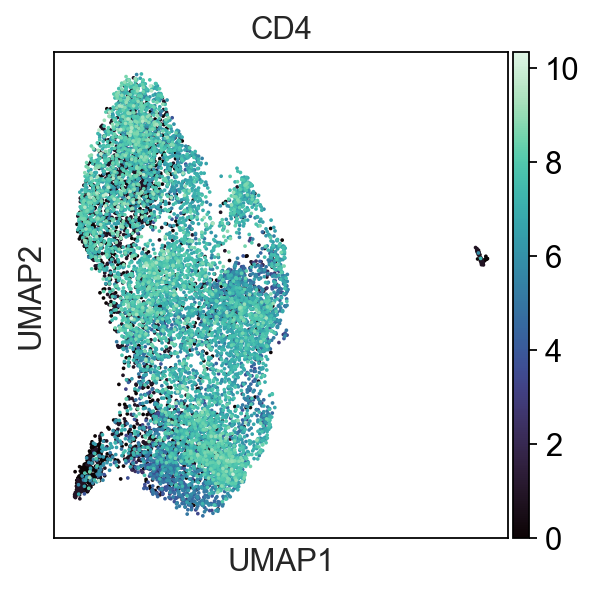

In [24]:
sc.pl.umap(adata, color='CD4',
           cmap='mako',
           vmin=0)

In [25]:
## Remove clusters of non-CD4s
adata = adata[adata.obs['leiden'] != '6']
adata = adata[adata.obs['leiden'] != '7']

In [26]:
sc.write('veatch_cd4_orig4.h5ad', adata)

### Export CD8 T cells

In [27]:
adata = adata_all[(adata_all.obs['Cell_Type_Experimental'] == 'T_CD8_memory') | (adata_all.obs['Cell_Type_Experimental'] == 'T_CD8_naive')]

In [28]:
sc.write('veatch_cd8_orig4.h5ad', adata)

## All 20 patients: T and B cells

### Import and clean data

In [29]:
adata1 = anndata.read_csv('data/Combined_TCR_BCR_DBEC_MolsPerCell_210223.csv',first_column_names=True)
tag1 = pd.read_csv('data/TCR_BCR_Sample_Tag_Calls_210223.csv',index_col=0)
vdj1 = pd.read_csv('data/TCR_BCR_VDJ_perCell_210223.csv', index_col=0)

adata2 = anndata.read_csv('data/Combined_TCR_BCR_DBEC_MolsPerCell_210210.csv',first_column_names=True)
tag2 = pd.read_csv('data/TCR_BCR_Sample_Tag_Calls_210210.csv',index_col=0)
vdj2 = pd.read_csv('data/all20 x198 x197 x205 x422 vdj_new.csv',index_col=0)

adata3 = anndata.read_csv('data/Combined_TCR_BCR_DBEC_MolsPerCell_210129.csv',first_column_names=True)
tag3 = pd.read_csv('data/TCR_BCR_Sample_Tag_Calls_210129.csv',index_col=0)
vdj3 = pd.read_csv('data/TCR_BCR_VDJ_perCell_210129.csv', index_col=0)

adata4 = anndata.read_csv('data/Combined_TCR_BCR_DBEC_MolsPerCell_210125.csv',first_column_names=True)
tag4 = pd.read_csv('data/TCR_BCR_Sample_Tag_Calls_210125.csv',index_col=0)
vdj4 = pd.read_csv('data/TCR_BCR_VDJ_perCell_210125.csv', index_col=0)

adata5 = anndata.read_csv('data/_1_Combined_TCR_BCR_DBEC_MolsPerCell_210114.csv',first_column_names=True)
tag5 = pd.read_csv('data/_1_TCR_BCR_Sample_Tag_Calls_210114.csv',index_col=0)
vdj5 = pd.read_csv('data/_1_TCR_BCR_VDJ_perCell_210114.csv', index_col=0)

In [30]:
vdj1.index = vdj1.index.astype('str')
vdj2.index = vdj2.index.astype('str')
vdj3.index = vdj3.index.astype('str')
vdj4.index = vdj4.index.astype('str')
vdj5.index = vdj5.index.astype('str')

tag1.index = tag1.index.astype('str')
tag2.index = tag2.index.astype('str')
tag3.index = tag3.index.astype('str')
tag4.index = tag4.index.astype('str')
tag5.index = tag5.index.astype('str')

In [31]:
adata1.obs = adata1.obs.join(tag1)
adata1.obs = adata1.obs.join(vdj1)

adata2.obs = adata2.obs.join(tag2)
adata2.obs = adata2.obs.join(vdj2)

adata3.obs = adata3.obs.join(tag3)
adata3.obs = adata3.obs.join(vdj3)

adata4.obs = adata4.obs.join(tag4)
adata4.obs = adata4.obs.join(vdj4)

adata5.obs = adata5.obs.join(tag5)
adata5.obs = adata5.obs.join(vdj5)

### Combine into single anndata object

In [32]:
adata = adata1.concatenate([adata2,adata3,adata4,adata5])

### Filter low quality cells & doublets

In [33]:
sc.pp.filter_cells(adata,min_counts=100)
sc.pp.filter_cells(adata,min_genes=10)
sc.pp.filter_genes(adata,min_counts=10)

filtered out 17 genes that are detected in less than 10 counts


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.1%
Elapsed time: 83.1 seconds


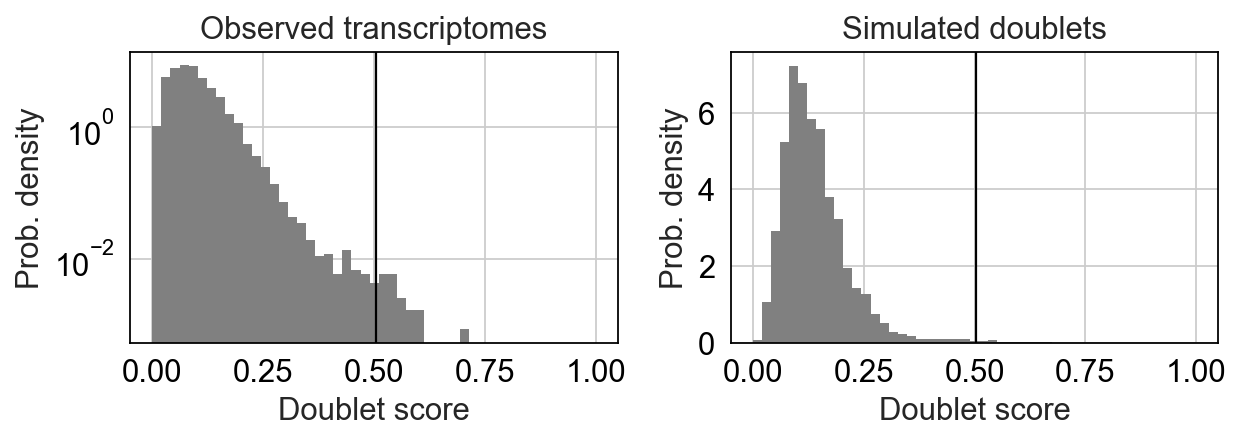

In [34]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
adata = adata[~adata.obs['predicted_doublets']]

In [35]:
adata = adata[adata.obs['Sample_Name'] != 'Undetermined']
adata = adata[adata.obs['Sample_Name'] != 'Multiplet']

In [36]:
adata.obs['Sample_Name'][adata.obs['Sample_Name'] == 'X226A'] = 'X226'

### Normalize and batch correct

In [37]:
adata.var['type'] = 'gene'
adata.var['type'][:53] = 'protein'

Trying to set attribute `.var` of view, copying.


In [38]:
adata.var['name'] = adata.var.index.values

for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, '|')[0]})
    
for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, ':')[0]})

In [39]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


In [40]:
adata_ab = adata[:,adata.var['type'] == 'protein']

for x in adata_ab.var.index:
    adata_ab.var = adata_ab.var.rename(index={x:x+" (ab)"})
    
for x in adata_ab.var.index:
    y = x[:-5]
    adata.obs[x] = np.sum(adata[:,y].X,axis=1)

In [41]:
adata = adata[:,adata.var['type'] == 'gene']

In [42]:
sc.write('veatch_tb_all20_precombat.h5ad', adata)

Trying to set attribute `.obs` of view, copying.
... storing 'Sample_Tag' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sample_Name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_V_gene_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_D_gene_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_J_gene_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_C_gene_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_CDR3_Nucleotide_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Heavy_CDR3_Translation_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Light_V_gene_Dominant' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BCR_Light_J_

In [43]:
sc.pp.combat(adata,key='Sample_Name')

Standardizing Data across genes.

Found 20 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



### Export data

In [44]:
sc.write('veatch_tb_all20.h5ad', adata)

In [45]:
adata_all = adata.copy()

### Export CD4 T cells

In [46]:
adata = adata_all[(adata_all.obs['Cell_Type_Experimental'] == 'T_CD4_memory') | (adata_all.obs['Cell_Type_Experimental'] == 'T_CD4_naive')]

In [47]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:25)


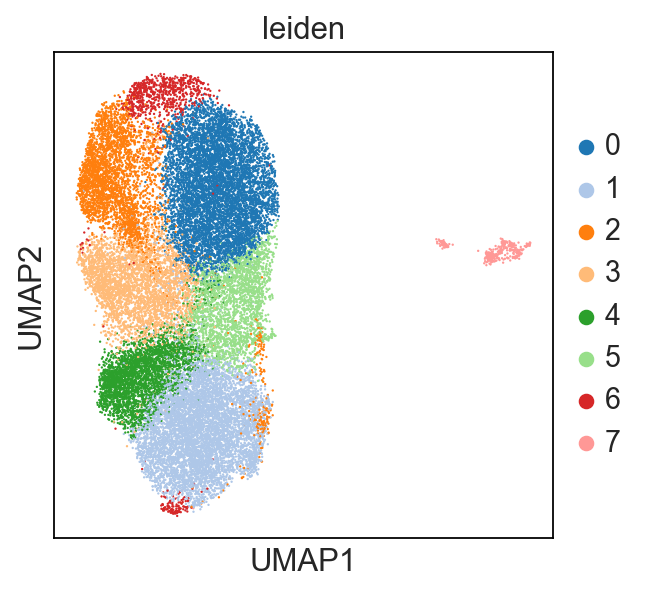

In [48]:
sc.pl.umap(adata, color='leiden',
           palette=sns.color_palette("tab20", 20))

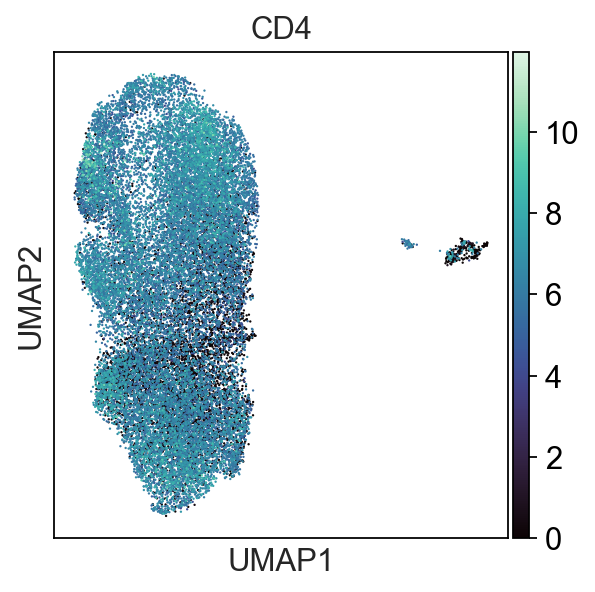

In [49]:
sc.pl.umap(adata, color='CD4',
           cmap='mako',vmin=0)

In [50]:
adata = adata[adata.obs['leiden'] != '7']

In [51]:
sc.write('veatch_cd4_all20.h5ad', adata)

### Export CD8 T cells

In [52]:
adata = adata_all[(adata_all.obs['Cell_Type_Experimental'] == 'T_CD8_memory') | (adata_all.obs['Cell_Type_Experimental'] == 'T_CD8_naive')]

In [53]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


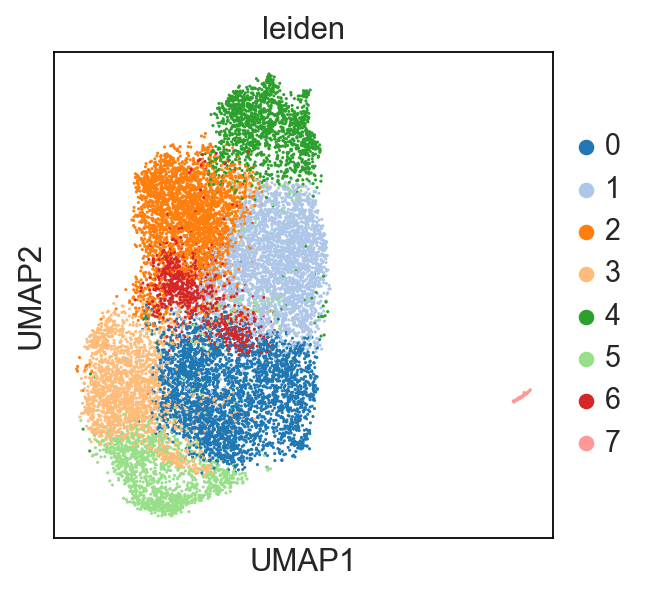

In [54]:
sc.pl.umap(adata, color='leiden',
           palette=sns.color_palette("tab20", 20))

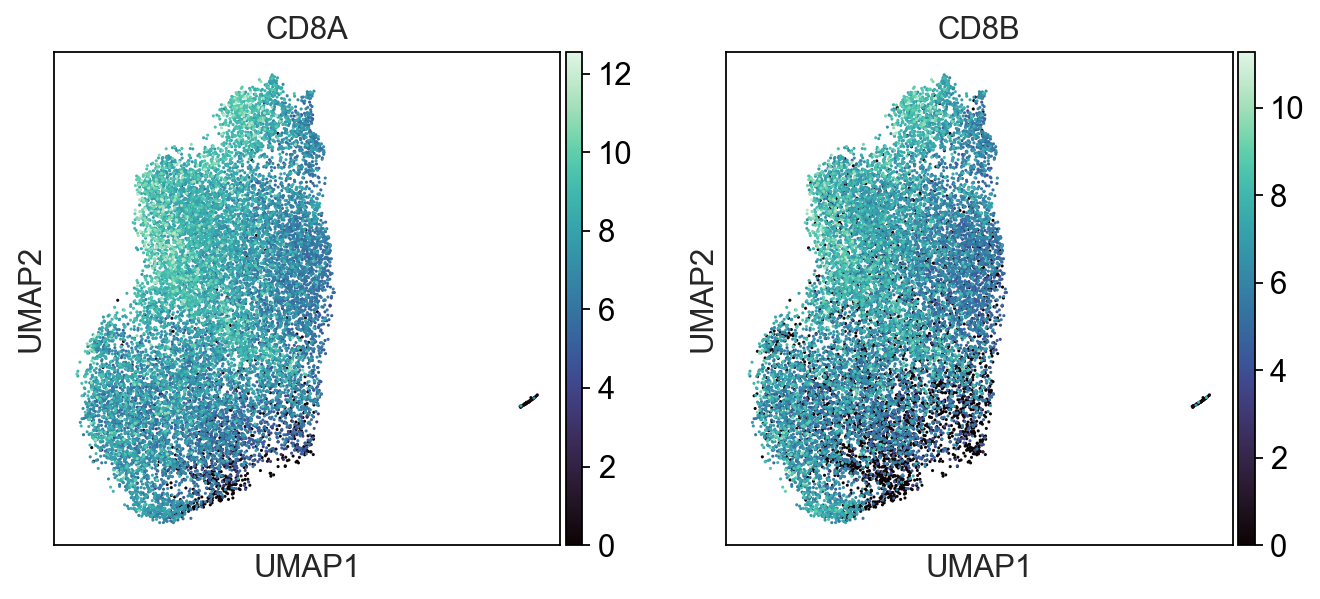

In [55]:
sc.pl.umap(adata, color=['CD8A','CD8B'],
           cmap='mako', vmin=0)

In [56]:
adata = adata[adata.obs['leiden'] != '7']

In [57]:
sc.write('veatch_cd8_all20.h5ad', adata)

### Export B cells

In [58]:
adata = adata_all[(adata_all.obs['Cell_Type_Experimental'] == 'B')]

In [59]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


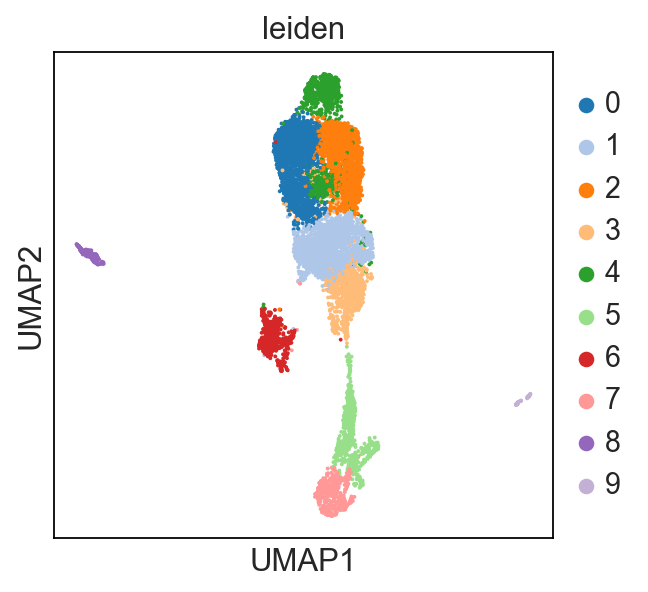

In [60]:
sc.pl.umap(adata, color='leiden',
           palette=sns.color_palette("tab20", 20))

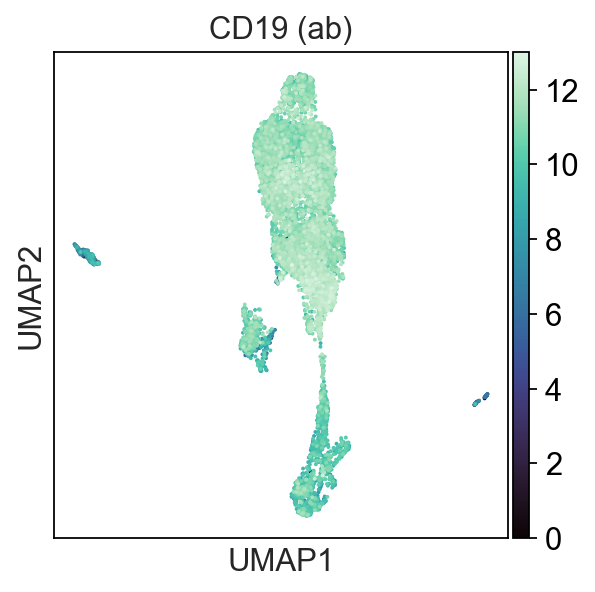

In [61]:
sc.pl.umap(adata, color='CD19 (ab)',
           vmin=0, cmap='mako')

In [62]:
adata = adata[adata.obs['leiden'] != '8']
adata = adata[adata.obs['leiden'] != '9']

In [63]:
sc.write('veatch_b_all20.h5ad', adata)

## All 20 patients: myeloid cells

### Import and clean data

In [64]:
adata1 = anndata.read_csv('data/Combined_mRNA_Abseq_Stag_DBEC_MolsPerCell-210208-myeloid.csv',first_column_names=True)
tag1 = pd.read_csv('data/mRNA_Abseq_Stag_Sample_Tag_Calls-210208-myeloid.csv',index_col=0)
labels1 = pd.read_csv('data/Combined_mRNA_Abseq_Stag_cell_type_experimental-210208-myeloid.csv',index_col=0)

adata2 = anndata.read_csv('data/Combined_mRNA_AbSeq_STag_DBEC_MolsPerCell-210222-myeloid.csv',first_column_names=True)
tag2 = pd.read_csv('data/mRNA_AbSeq_STag_Sample_Tag_Calls-210222-myeloid.csv',index_col=0)
labels2 = pd.read_csv('data/Combined_mRNA_AbSeq_STag_cell_type_experimental-210222-myeloid.csv',index_col=0)

In [65]:
tag1.index = tag1.index.astype('str')
tag2.index = tag2.index.astype('str')

labels1.index = labels1.index.astype('str')
labels2.index = labels2.index.astype('str')

In [66]:
adata1.obs = adata1.obs.join(tag1)
adata1.obs = adata1.obs.join(labels1)

adata2.obs = adata2.obs.join(tag2)
adata2.obs = adata2.obs.join(labels2)

### Combine into single anndata object

In [67]:
adata = adata1.concatenate(adata2)

### Filter low quality cells & doublets


In [68]:
sc.pp.filter_cells(adata,min_counts=100)
sc.pp.filter_cells(adata,min_genes=10)
sc.pp.filter_genes(adata,min_counts=10)

filtered out 15 genes that are detected in less than 10 counts


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 6.9 seconds


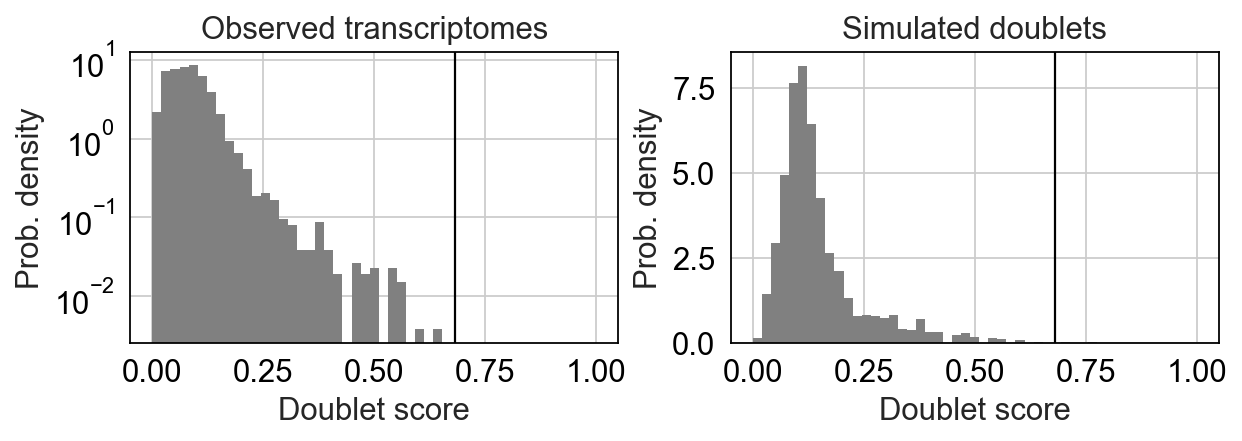

In [69]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
adata = adata[~adata.obs['predicted_doublets']]

In [70]:
adata = adata[adata.obs['Sample_Name'] != 'Undetermined']
adata = adata[adata.obs['Sample_Name'] != 'Multiplet']

### Normalize and batch correct

In [71]:
adata.var['type'] = 'gene'
adata.var['type'][:53] = 'protein'

Trying to set attribute `.var` of view, copying.


In [72]:
adata.var['name'] = adata.var.index.values

for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, '|')[0]})
    
for x in adata.var.index:
    adata.var = adata.var.rename(index={x:str.split(x, ':')[0]})

In [73]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


In [74]:
adata_ab = adata[:,adata.var['type'] == 'protein']

for x in adata_ab.var.index:
    adata_ab.var = adata_ab.var.rename(index={x:x+" (ab)"})

for x in adata_ab.var.index:
    y = x[:-5]
    adata.obs[x] = np.sum(adata[:,y].X,axis=1)

In [75]:
adata = adata[:,adata.var['type'] == 'gene']

In [76]:
adata20 = sc.read('veatch_tb_all20_precombat.h5ad')

In [77]:
adata = adata.concatenate(adata20)

In [78]:
sc.pp.combat(adata,key='Sample_Name')

... storing 'Sample_Tag' as categorical
... storing 'Sample_Name' as categorical
... storing 'Cell_Type_Experimental' as categorical
... storing 'BCR_Heavy_V_gene_Dominant' as categorical
... storing 'BCR_Heavy_D_gene_Dominant' as categorical
... storing 'BCR_Heavy_J_gene_Dominant' as categorical
... storing 'BCR_Heavy_C_gene_Dominant' as categorical
... storing 'BCR_Heavy_CDR3_Nucleotide_Dominant' as categorical
... storing 'BCR_Heavy_CDR3_Translation_Dominant' as categorical
... storing 'BCR_Light_V_gene_Dominant' as categorical
... storing 'BCR_Light_J_gene_Dominant' as categorical
... storing 'BCR_Light_C_gene_Dominant' as categorical
... storing 'BCR_Light_CDR3_Nucleotide_Dominant' as categorical
... storing 'BCR_Light_CDR3_Translation_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_V_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_J_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_C_gene_Dominant' as categorical
... storing 'TCR_Alpha_Gamma_CDR3_Nucleot

Standardizing Data across genes.

Found 20 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



### Export data

In [79]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:32)


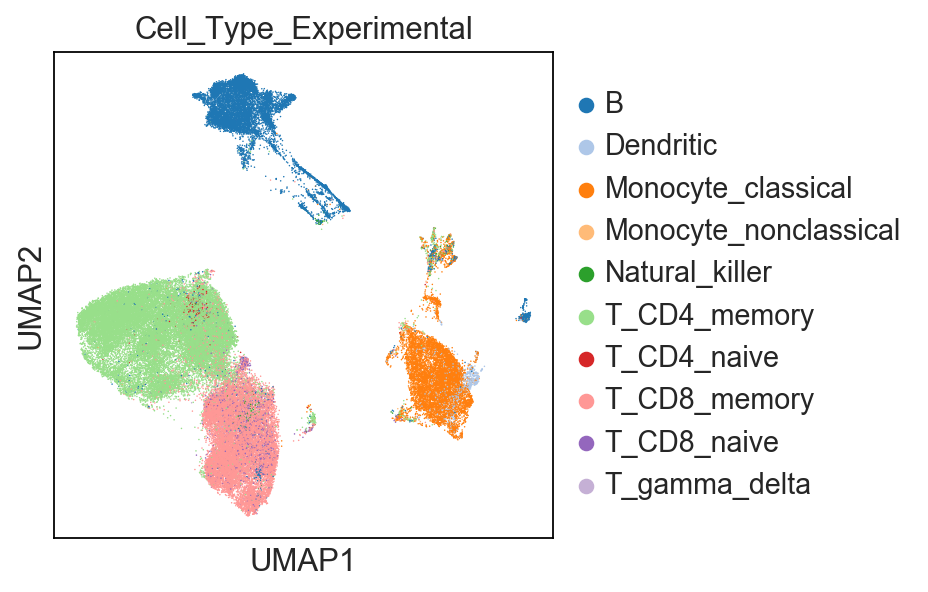

In [80]:
sc.pl.umap(adata, color='Cell_Type_Experimental',
           palette=sns.color_palette("tab20", 20),
           alpha = 1)

In [81]:
adata = adata[(adata.obs['leiden'] == '9') |(adata.obs['Cell_Type_Experimental'] == 'Monocyte_classical') | (adata.obs['Cell_Type_Experimental'] == 'Dendritic') | (adata.obs['Cell_Type_Experimental'] == 'Monocyte_nonclassical')]

In [82]:
sc.write('veatch_myeloid_all20.h5ad', adata)